In [176]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Audio

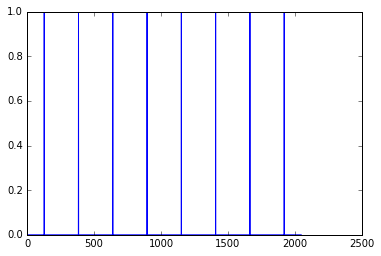

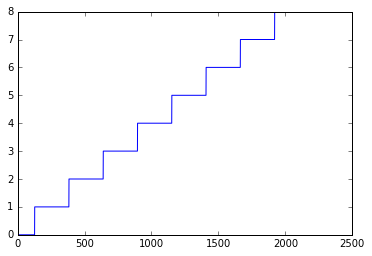

In [2]:
imp = signal.unit_impulse(256, 128)
n = np.arange(-128, 128)


train = np.tile(imp, 8)
plt.plot(train)
plt.show()

plt.plot(np.cumsum(train))
plt.show()


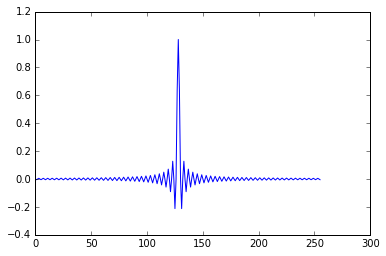

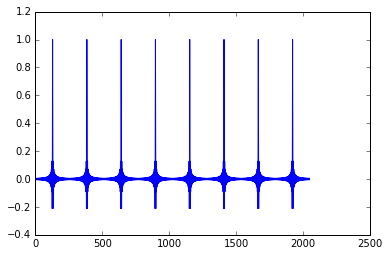

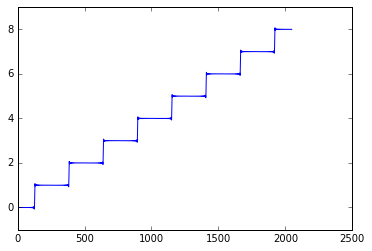

In [3]:
n = np.arange(-128, 128)
bli = np.sinc(n/2)
plt.plot(bli)
plt.show()

blit = np.tile(bli, 8)
plt.plot(blit)
plt.show()

plt.plot(np.cumsum(blit)/2)
plt.show()


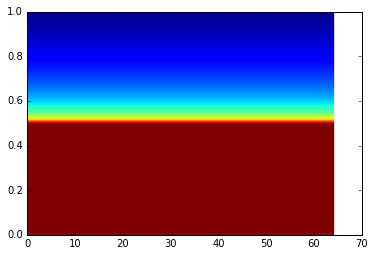

In [7]:
plt.specgram(bli)
plt.show()

# BLIT
A BLIT signal, $y(n)$ with $P$ as Period in Samples is given by:

$$ y(n) = (M/P) Sinc_M[(M/P)n] $$
where


$$ Sinc_M(x) = \frac{sin( \pi x)}{M sin(\pi x /M)}$$

$M$ = Number of Harmonics

Calculated via
$$ M = 2\cdot floor(P/2)+1 $$

## Issues:
Not working for integer frequencies for some reason.


In [389]:
def sincM(x, M):
    return np.sin(np.pi*x)/(M*np.sin((np.pi*x)/M))
def sampledSinc(n,M,P):
    return (M/P)*sincM((M/P)*n, M)

In [384]:
T = 1. #sec
fs = 44100. #Hz
N = T*fs #num Samples
n = np.arange(N)+1 #sample Index
t = n/fs #time

In [385]:
freq = 100.001 #Hz
T1 = 1./freq #period in Seconds
Ts = 1./fs #sampling Period
P = T1/Ts # (1/freq)*fs
M = 2*np.floor(P/2.)+1 #Number of Harmonics
y = sampledSinc(n, M, P)

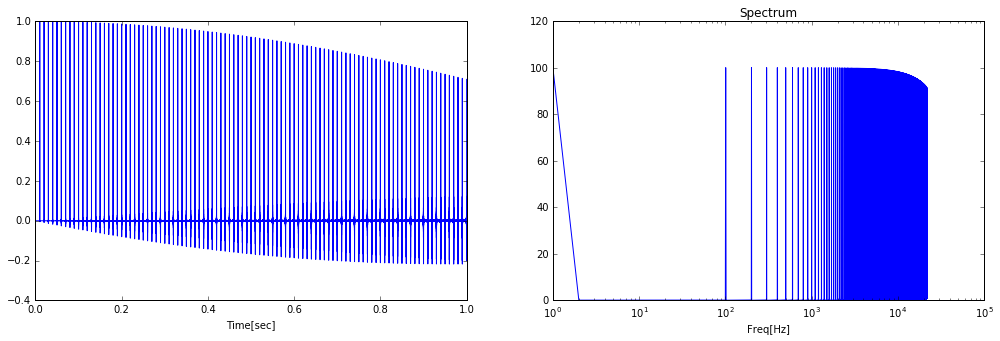

In [386]:
plt.figure(figsize=[17,5])
plt.subplot(121)
plt.plot(t,y)
plt.xlabel('Time[sec]')
plt.subplot(122)

plt.semilogx(np.linspace(1,fs/2, int(N/2)), abs(np.fft.fft(y))[0:int(N/2)])
plt.xlabel('Freq[Hz]')
plt.title('Spectrum')
plt.show()


In [387]:
Audio(data=y, rate=fs)

## References
https://ccrma.stanford.edu/~stilti/papers/blit.pdf